<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp?1" width="100px"></a>
</td>
</tr>
</table>

# Chapter 7: Finetuning To Follow Instructions

In [2]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.3
tiktoken version: 0.9.0
torch version: 2.7.0
tqdm version: 4.67.1
tensorflow version: 2.19.0


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/overview.webp?1" width=500px>

## 7.1 Introduction to instruction finetuning

- In chapter 5, we saw that pretraining an LLM involves a training procedure where it learns to generate one word at a time
- Hence, a pretrained LLM is good at text completion, but it is not good at following instructions
- In this chapter, we teach the LLM to follow instructions better

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/instruction-following.webp" width=500px>

- The topics covered in this chapter are summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-1.webp?1" width=500px>

## 7.2 Preparing a dataset for supervised instruction finetuning

- We will work with an instruction dataset I prepared for this chapter

代码实现并执行了一个函数来下载这个数据集，该数据集保存在一个相对较小的 JSON 格式的文件中（仅 204 KB）​。

In [3]:
import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


- Each item in the `data` list we loaded from the JSON file above is a dictionary in the following form

In [4]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


- Note that the `'input'` field can be empty:

In [5]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


- Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
- There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

展示了两种样本格式，这通常也被称为提示词风格，常用于训练知名的大语言模型，比如 Alpaca 和 Phi-3。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/prompt-style.webp?1" width=500px>

大语言模型指令微调中不同提示词风格的比较。Alpaca 风格（左）为指令、输入和回复定义了不同的小节，其采用的是结构化的形式；Phi-3 风格（右）则使用了更简单的形式，主要借助的是特殊词元 <|user|> 和 <|assistant|>

- In this chapter, we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
- Below, we format the input that we will pass as input to the LLM

下面定义一个 format_input 函数，然后我们可以使用它将 data 列表中的样本转换成Alpaca 风格的输入格式，如代码清单 7-2 所示。

In [6]:
def format_input(entry):
    """格式化Alpaca风格的指令输入
    
    Args:
        entry (dict): 包含指令和输入的字典，包含两个键：
            instruction (str): 任务指令文本
            input (str): 可选的输入上下文
            
    Returns:
        str: 格式化后的完整提示文本，包含指令和输入（如果有）
    """
    # 构建指令基础模板
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 添加可选输入部分（当输入非空时）
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text


- A formatted response with input field looks like as shown below

In [7]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


- Below is a formatted response without an input field

值得注意的是，如果 'input' 键对应的值是空的，那么 format_input 函数就会跳过可选的 ### Input: 部分。可以把 format_input 函数用在我们之前检查过的 data[999]上：

In [8]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


- Lastly, before we prepare the PyTorch data loaders in the next section, we divide the dataset into a training, validation, and test set

在设置 PyTorch 数据集加载器之前，还需要将数据集分为训练集、验证集和测试集，所用方法与我们在第6章中处理垃圾消息分类数据集时相似。代码清单 7-3 展示了如何设置这些数据集的比例。

In [9]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [10]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## 7.3 Organizing data into training batches

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-2.webp?1" width=500px>

- We tackle this dataset batching in several steps, as summarized in the figure below

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/detailed-batching.webp?1" width=500px>

实现批处理过程包括以下 5 个子步骤：
- (2.1) 应用提示词模板；
- (2.2) 使用前几章提到的词元化方法；
- (2.3) 添加填充词元；
- (2.4) 创建目标词元 ID；
- (2.5) 在损失函数中用 -100 占位符词元来掩码填充词元

- First, we implement an `InstructionDataset` class that pre-tokenizes all inputs in the dataset, similar to the `SpamDataset` in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/pretokenizing.webp" width=500px>

实现一个指令数据集类

In [11]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        """数据集初始化方法
        
        Args:
            data: 原始指令数据集，每个元素应包含instruction/input/output字段
            tokenizer: 用于文本编码的分词器
        """
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            # 生成指令+输入部分（使用之前定义的format_input函数）
            instruction_plus_input = format_input(entry)
            # 构建响应部分的模板
            response_text = f"\n\n### Response:\n{entry['output']}"
            # 组合完整文本：指令 + 输入 + 响应
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)  # 对完整文本进行编码
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

- Similar to chapter 6, we want to collect multiple training examples in a batch to accelerate training; this requires padding all inputs to a similar length
- Also similar to the previous chapter, we use the `<|endoftext|>` token as a padding token

一个值得注意的细节是，可以直接将 <|endoftext|> 对应的词元 ID 拼接到预词元化的模型输入中，而无须将 <|endoftext|> 拼接在输入文本的末尾。可以使用分词器的.encode 方法对 <|endoftext|> 进行编码，以确定应该使用哪个词元 ID：

In [12]:
# 导入OpenAI的分词库（也适用于GPT-2）
import tiktoken

# 初始化GPT-2分词器（与GPT-3使用的分词方式兼容）
tokenizer = tiktoken.get_encoding("gpt2")

# 对结束标记进行编码测试，显式允许处理特殊符号<|endoftext|>
# allowed_special参数用于控制哪些特殊符号应该被保留
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))


[50256]


- In chapter 6, we padded all examples in a dataset to the same length
  - Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
  - This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/padding.webp" width=500px>

使用词元 ID 50256 对批次中的训练样本进行填充，以确保每个批次的长度一致。但每个批次的长度可能不同，比如第一批数据就与第二批数据长度不同

In [13]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    """自定义批处理整理函数（初版）
    
    Args:
        batch: 输入批次数据，每个元素是token id列表
        pad_token_id: 填充token的ID（默认GPT-2的结束符ID）
        device: 输出张量的目标设备
        
    Returns:
        inputs_tensor: 填充对齐后的输入张量
    """
    # 计算批次最大长度时+1，为后续处理留出空间（如目标序列生成）
    batch_max_length = max(len(item)+1 for item in batch)

    # 初始化输入列表
    inputs_lst = []

    for item in batch:
        new_item = item.copy()  # 避免修改原始数据
        # 添加结束标记作为序列终止符
        new_item += [pad_token_id]
        # 填充到批次最大长度（包含额外的一个填充位置）
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 截断最后一个填充位，保留给后续处理使用
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # 堆叠张量并转移设备（如GPU）
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor



In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-4.webp?1" width=500px>

我们刚刚实现了第一个自定义的聚合函数，用于从输入列表中创建批次。然而，正如之前所提到的，我们还需要生成与输入词元 ID 批次对应的目标词元 ID。这些目标词元 ID（参见图7-9）非常重要，因为它们代表我们期望模型生成的内容，并且在训练中用来计算损失，以便进行权重更新。因此，我们需要对自定义聚合函数进行修改，以便除了输入词元 ID 之外，还能返回目标词元 ID。

- Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
- Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/inputs-targets.webp?1" width=400px>

大语言模型指令微调过程中使用的输入词元和目标词元之间的对应关系。对每个输入序列而言，首先将其向左移动一个词元的位置，然后将输入序列的第一个词元忽略，最后在尾部加入结束符词元即可得到其对应的目标序列

实现批处理过程包括 5 个子步骤。此刻我们关注第(2.4) 步，这一步构建了目标词元 ID。这一步至关重要，因为它使得模型能够学习并预测需要生成的词元

In [15]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    """自定义批处理整理函数（第二版），生成输入-目标对
    
    Args:
        batch: 输入批次数据，每个元素是token id列表
        pad_token_id: 填充token的ID（默认GPT-2的结束符ID）
        device: 输出张量的目标设备
        
    Returns:
        tuple: (输入张量, 目标张量) 目标张量是输入右移一位的结果
    """
    # 计算批次最大长度时+1，为右移目标留出空间
    batch_max_length = max(len(item)+1 for item in batch)

    # 初始化输入和目标列表
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()  # 防止修改原始数据
        # 添加结束标记作为序列终止符
        new_item += [pad_token_id]
        # 填充到批次最大长度（包含右移需要的额外位置）
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 输入取前n-1个token，目标取后n-1个token（实现右移）
        inputs = torch.tensor(padded[:-1])  # 输入序列
        targets = torch.tensor(padded[1:])  # 右移后的目标序列
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 堆叠张量并转移设备（如GPU），保持输入与目标对齐
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor



In [16]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


在下一步中，我们会为所有填充词元都分配一个 -100 占位符值（参见图7-11 突出显示的部分）​。这个特殊值使我们能够在计算训练损失时排除填充词元的影响，从而确保只有有效的数据会影响模型的学习。我们将在实现此修改后更详细地讨论这一过程。​（值得说明的是，分类微调时无须担心这个问题，因为我们只根据最后的输出词元对模型进行训练。​）

- Next, we introduce an `ignore_index` value to replace all padding token IDs with a new value; the purpose of this `ignore_index` is that we can ignore padding values in the loss function (more on that later)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/batching-step-5.webp?1" width=500px>

- Concretely, this means that we replace the token IDs corresponding to `50256` with `-100` as illustrated below

实现批处理过程包括 5 个子步骤。在创建目标序列的过程中，我们将输入词元序列向左移动一个位置并附加一个结束符词元。接下来，在第(2.5) 步中，我们将结束符（填充）词元替换为占位符值(-100)

不过，值得注意的是，我们在目标列表中保留了一个结束符词元，ID 为 50256，如图7-12 所示。保留此词元有助于大语言模型学会何时根据指令生成结束符词元，一般我们将其作为生成的回复已经完成的指示符。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ignore-index.webp?1" width=500px>

- (In addition, we also introduce the `allowed_max_length` in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model)

我们修改了自定义聚合函数，以将目标列表中 ID 为 50256的词元替换为 -100。此外，我们还引入了一个 allowed_max_length 参数，以选择性地限制样本的长度。这一调整在处理超过GPT-2 模型支持的 1024 个词元上下文大小的数据集时将非常有用。

In [17]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    """自定义批处理整理函数（最终版）
    
    Args:
        batch: 输入批次数据，每个元素是token id列表
        pad_token_id: 填充token的ID（默认GPT-2的结束符ID）
        ignore_index: 需要忽略的损失计算位置（默认-100）
        allowed_max_length: 允许的最大序列长度（None表示不限制）
        device: 输出张量的目标设备
        
    Returns:
        tuple: (输入张量, 目标张量) 目标张量中后续填充位置被标记为忽略
    """
    # 计算批次最大长度时+1，为右移目标留出空间
    batch_max_length = max(len(item)+1 for item in batch)

    # 初始化输入和目标列表
    inputs_lst, targets_lst = [], []

    for item in batch:
        # ... [existing copy and padding logic] ...

        # 创建掩码标记后续填充位置（仅保留第一个填充符用于损失计算）
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index  # 后续填充位置设为忽略值

        # 可选长度截断（防止超出模型最大长度限制）
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]  # 截断输入序列
            targets = targets[:allowed_max_length]  # 同步截断目标序列

        # ... [existing appends] ...

    # 堆叠张量并转移设备，保持输入与目标对齐
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    """自定义批处理整理函数（最终版）
    
    Args:
        batch: 输入批次数据，每个元素是token id列表
        pad_token_id: 填充token的ID（默认GPT-2的结束符ID）
        ignore_index: 需要忽略的损失计算位置（默认-100）
        allowed_max_length: 允许的最大序列长度（None表示不限制）
        device: 输出张量的目标设备
        
    Returns:
        tuple: (输入张量, 目标张量) 目标张量中后续填充位置被标记为忽略
    """
    # 计算批次最大长度时+1，为右移目标留出空间
    batch_max_length = max(len(item)+1 for item in batch)

    # 初始化输入和目标列表
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()  # 防止修改原始数据
        # 添加结束标记作为序列终止符
        new_item += [pad_token_id]
        # 填充到批次最大长度（包含右移需要的额外位置）
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # 输入取前n-1个token，目标取后n-1个token（实现右移）
        inputs = torch.tensor(padded[:-1])  # 输入序列
        targets = torch.tensor(padded[1:])  # 右移后的目标序列

        # 创建掩码标记后续填充位置（仅保留第一个填充符用于损失计算）
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index  # 后续填充位置设为忽略值

        # 可选长度截断（防止超出模型最大长度限制）
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]  # 截断输入序列
            targets = targets[:allowed_max_length]  # 同步截断目标序列

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 堆叠张量并转移设备，保持输入与目标对齐
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor



In [18]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


看起来修改后的聚合函数在正常工作，它成功地在目标列表对应位置插入了词元 ID -100。但是，这一调整背后的逻辑是什么呢？让我们探讨一下此修改的根本目的。

- Let's see what this replacement by -100 accomplishes
- For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1, similar to chapter 6
- If we have the following logits values (outputs of the last layer of the model), we calculate the following loss

为方便理解，可以考虑一个简单的示例，其中输出逻辑值(logits)的每一维都对应着模型词汇表中的一个潜在词元。下面的代码展示了在训练过程中交叉熵损失（参见第5章）是如何计算的，这一过程与我们在预训练和分类微调模型时的操作类似：

In [19]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


- Now, adding one more training example will, as expected, influence the loss

正如预期的那样，增加一个额外的词元会影响损失的计算：

In [20]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


- Let's see what happens if we replace the class label of one of the examples with -100

到目前为止，我们已经使用 PyTorch的交叉熵损失函数进行了若干简单示例计算，这个损失函数正是我们在预训练和分类微调时使用的损失函数。接下来，来看一个有趣的情况：如果将第三个目标词元 ID 替换为 -100，会发生什么呢？

In [21]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


- As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
- By default, PyTorch has the `cross_entropy(..., ignore_index=-100)` setting to ignore examples corresponding to the label -100
- Using this -100 `ignore_index`, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
- However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete

- In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below (this is a recommended reader exercise after completing the chapter)

- 得到的损失与之前示例计算中的损失相同。换言之，此时交叉熵损失函数忽略了targets_3 向量中的第三项(-100)所对应的损失。​（如果你对此感兴趣，可以尝试将-100 替换为其他非 0 或 1的词元，你将会发现错误。​）
- 那么，-100 究竟有什么特别之处，使交叉熵损失能够忽略它呢？原来，在 PyTorch中，交叉熵函数的默认设置为 cross_entropy(..., ignore_index=-100)。这意味着它会忽略标记为 -100的目标。我们利用这个 ignore_index 来忽略那些用于填充训练示例以使每个批次具有相同长度的额外结束符（填充）词元。然而，我们需要在目标中保留结束符词元 ID 50256，因为它有助于大语言模型学习生成结束符词元，从而在适当的时候结束回复。
- 除了掩码填充词元，实践中我们通常还会掩码与指令相关的目标词元，如图7-13 所示。通过掩码与指令对应的目标词元，交叉熵损失可以仅针对生成的回复目标词元进行计算。因此，模型的训练更专注于生成准确的回复，而非记住指令，这样可以帮助减少过拟合。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/mask-instructions.webp?1" width=600px>

训练期间，格式化输入文本被词元化并送入大语言模型中（左）​；大语言模型准备的目标文本，我们可以选择掩码指令部分，即将相应的词元替换为损失的ignore_index 值 -100（右）

## 7.4 Creating data loaders for an instruction dataset

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-3.webp?1" width=500px>

- Another additional detail of the previous `custom_collate_fn` function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the `custom_collate_fn` as part of the data loader
- Using the `partial` function from Python's `functools` standard library, we create a new function with the `device` argument of the original function pre-filled

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cpu


为了在将 custom_collate_fn 函数应用于 PyTorch DataLoader 类时重用所选择的设备设置，我们利用 Python的 functools 标准库中的 partial 函数创建该函数的新版本并预先填充设备参数。此外，可以将 allowed_max_length 设置为 1024，这样数据就会被截断到 GPT-2 模型支持的最大上下文长度，稍后我们将对其进行微调。

这种写法常用于：

- 简化重复的函数调用
- 保持参数配置的一致性
- 适配需要固定参数的接口（如PyTorch DataLoader的collate_fn）

In [23]:
from functools import partial

# 创建定制化的数据整理函数，预绑定设备参数和最大序列长度
customized_collate_fn = partial(
    custom_collate_fn,        # 原始数据整理函数
    device=device,            # 指定计算设备（CPU/GPU）
    allowed_max_length=1024   # 允许的最大序列长度（防止内存溢出）
)


- Next, we instantiate the data loaders similar to previous chapters, except that we now provide our own collate function for the batching process

In [24]:
from torch.utils.data import DataLoader

# 数据加载配置参数
num_workers = 0    # 数据加载子进程数（0表示主进程加载）
batch_size = 8      # 每个批次的样本数量

# 设置随机种子保证可重复性
torch.manual_seed(123)  # 固定所有随机数生成器的种子

# 创建训练数据集和加载器
train_dataset = InstructionDataset(train_data, tokenizer)  # 自定义指令数据集
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,          # 使用预定义的批次大小
    collate_fn=customized_collate_fn, # 使用预配置的数据整理函数
    shuffle=True,                   # 每个epoch打乱数据顺序，确保模型不会记忆数据顺序
    drop_last=True,                 # 丢弃最后不完整的批次，避免最后不完整批次影响梯度计算
    num_workers=num_workers         # 保持加载进程数配置
)


In [25]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

该输出表明，第一个输入批次和目标批次的维度为 8 × 61，其中 8 是批次大小，61 是该批次中每个训练样本的词元数量。第二个输入批次和目标批次中的词元数量则有 76个，与第一个不同。由于我们使用了自定义的聚合函数，因此数据加载器能够创建不同长度的批次。在 7.5 节中，我们将加载一个预训练的大语言模型，并利用这个数据加载器对该模型进行微调。

In [26]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

- Let's see what the dimensions of the resulting input and target batches look like

In [27]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 63]) torch.Size([8, 63])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 59]) torch.Size([8, 59])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 57]) torch.Size([8, 57])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 58]) torch.Size([8, 58])
torch.Size([8, 61]) torch.

- As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
- Let's also double-check that the inputs contain the `<|endoftext|>` padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the `inputs` batch

In [28]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 42779,   597, 24993, 10135,   287,   262,
         1813,  6827,    13,   198,   198, 21017, 23412,    25,   198,   464,
          307,   315,  4135, 11376,   373,  5901,   351, 12734,    13,   198,
          198, 21017, 18261,    25,   198,   464,  4950, 11376,   373,  5901,
          351, 12734,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256])


- Similarly, we visually double-check that the targets contain the -100 placeholder tokens

In [29]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 42779,   597, 24993, 10135,   287,   262,  1813,
         6827,    13,   198,   198, 21017, 23412,    25,   198,   464,   307,
          315,  4135, 11376,   373,  5901,   351, 12734,    13,   198,   198,
        21017, 18261,    25,   198,   464,  4950, 11376,   373,  5901,   351,
        12734,    13, 50256,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100])


## 7.5 Loading a pretrained LLM

- In this section, we load a pretrained GPT model using the same code that we used in section 5.5 of chapter 5 and section 6.4 in chapter 6

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-4.webp?1" width=500px>

- However, instead of loading the smallest 124 million parameter model, we load the medium version with 355 million parameters since the 124 million model is too small for achieving qualitatively reasonable results via instruction finetuning

In [30]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt
# If the `previous_chapters.py` file is not available locally,
# you can import it from the `llms-from-scratch` PyPI package.
# For details, see: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# E.g.,
# from llms_from_scratch.ch04 import GPTModel
# from llms_from_scratch.ch05 import download_and_load_gpt2, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


- Before we start finetuning the model in the next section, let's see how it performs on one of the validation tasks

现在，让我们先花一些时间，通过将模型输出与预期的回复进行比较，来评估预训练的大语言模型在验证任务上的表现。这将为我们提供一个模型的基准性能指标，该指标反映了模型在未经微调的情况下在指令遵循任务中的表现情况，并能帮助我们更好地理解微调后的效果。下面我们将使用验证集中第一个样本进行评估

In [31]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [32]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)
# Alternatively:
# from llms_from_scratch.ch05 import (
#    generate_text_simple,
#    text_to_token_ids,
#    token_ids_to_text
# )


token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

- Note that the `generate` function we used in previous chapters returns the combined input and output text, which was convenient in the previous section for creating legible text
- To isolate the response, we can subtract the length of the instruction from the start of the `generated_text`

使用 generate 函数生成模型的回复，我们在第5章中使用过这个函数

In [33]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


- As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## 7.6 Finetuning the LLM on instruction data

- In this section, we finetune the model

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-5.webp?1" width=500px>

- Note that we can reuse all the loss calculation and training functions that we used in previous chapters

In [34]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)
# Alternatively:
# from llms_from_scratch.ch05 import (
#    calc_loss_loader,
#    train_model_simple,
# )


- Let's calculate the initial training and validation set loss before we start training (as in previous chapters, the goal is to minimize the loss)

In [35]:
# 将模型迁移到指定设备（GPU/CPU）
model.to(device)  

# 固定随机种子保证结果可复现
torch.manual_seed(123)  

# 禁用梯度计算以加速推理过程
with torch.no_grad():
    # 计算训练集损失（仅用5个批次估算）
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    # 计算验证集损失（仅用5个批次估算）
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

# 输出训练/验证损失指标
print("Training loss:", train_loss)    # 显示训练损失
print("Validation loss:", val_loss)   # 显示验证损失


Training loss: 3.8258963584899903
Validation loss: 3.761921453475952


- Note that the training is a bit more expensive than in previous chapters since we are using a larger model (355 million instead of 124 million parameters)
- The runtimes for various devices are shown for reference below (running this notebook on a compatible GPU device requires no changes to the code)

<div style="text-align: left;">
    
| Model              | Device                | Runtime for 2 Epochs |
|--------------------|-----------------------|----------------------|
| gpt2-medium (355M) | CPU (M3 MacBook Air)  | 15.78 minutes        |
| gpt2-medium (355M) | GPU (M3 MacBook Air)  | 10.77 minutes        |
| gpt2-medium (355M) | GPU (L4)              | 1.83 minutes         |
| gpt2-medium (355M) | GPU (A100)            | 0.86 minutes         |
| gpt2-small (124M)  | CPU (M3 MacBook Air)  | 5.74 minutes         |
| gpt2-small (124M)  | GPU (M3 MacBook Air)  | 3.73 minutes         |
| gpt2-small (124M)  | GPU (L4)              | 0.69 minutes         |
| gpt2-small (124M)  | GPU (A100)            | 0.39 minutes         |

</div>

- I ran this notebook using the `"gpt2-medium (355M)"` model

In [37]:
import time  # 导入时间模块用于计算训练耗时

# 记录训练开始时间戳
start_time = time.time()  

# 固定随机种子保证训练可复现
torch.manual_seed(123)  

# 初始化AdamW优化器（适合transformer模型）
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.00005,          # 较低学习率用于微调
    weight_decay=0.1     # 较强的权重衰减防止过拟合
)

num_epochs = 2  # 设置训练周期数

# 执行模型训练流程
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs,  # 总训练轮次
    eval_freq=5,            # 每5个batch验证一次 
    eval_iter=5,            # 每次验证用5个batch
    start_context=format_input(val_data[0]),  # 取验证集首样本作为生成起点
    tokenizer=tokenizer     # 传入分词器用于文本生成
)

# 计算总训练时长（分钟）
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")  # 保留两位小数输出


Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.945
Ep 1 (Step 000015): Train loss 0.856, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.753, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.798, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.790
Ep 1 (Step 000050): Train loss 0.662, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.764
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.652, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

- As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values
- Furthermore, based on the response text printed after each epoch, we can see that the model correctly follows the instruction to convert the input sentence `'The chef cooks the meal every day.'` into passive voice `'The meal is cooked every day by the chef.'` (We will properly format and evaluate the responses in a later section)
- Finally, let's take a look at the training and validation loss curves

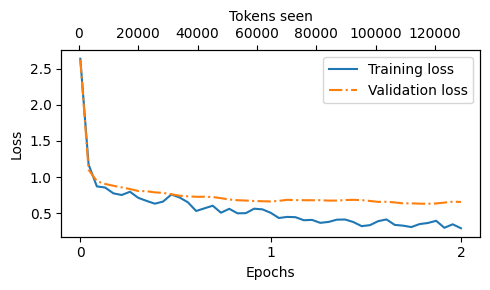

In [39]:
from previous_chapters import plot_losses
# Alternatively:
# from llms_from_scratch.ch05 import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- As we can see, the loss decreases sharply at the beginning of the first epoch, which means the model starts learning quickly
- We can see that slight overfitting sets in at around 1 training epoch

## 7.7 Extracting and saving responses

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-6.webp?1" width=500px>

- In this section, we save the test set responses for scoring in the next section
- We also save a copy of the model for future use
- But first, let's take a brief look at the responses generated by the finetuned model

In [41]:
# 设置随机种子保证结果可复现
torch.manual_seed(123)

# 遍历前3个测试样本
for entry in test_data[:3]:
    # 格式化输入文本（添加指令模板）
    input_text = format_input(entry)

    # 生成token序列（使用模型自回归生成）
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,      # 限制生成的最大token数量
        context_size=BASE_CONFIG["context_length"],  # 使用配置中的上下文长度
        eos_id=50256             # 结束符token ID（对标GPT-2）
    )
    
    # 将token序列解码为文本
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    # 提取模型响应部分（去除输入文本和模板标记）
    response_text = (
        generated_text[len(input_text):]  # 截取输入文本之后的内容
        .replace("### Response:", "")     # 移除响应模板标记
        .strip()                          # 去除首尾空白
    )

    # 打印对比结果
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")  # 标注正确答案
    print(f"\nModel response:\n>> {response_text.strip()}")  # 显示模型生成结果
    print("-------------------------------------")  # 分隔线


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

- As we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well
- The answers to the first and last instructions are clearly correct
- The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)
- Most importantly, we can see that model evaluation is not as straightforward as in the previous chapter, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy
- In practice, instruction-finetuned LLMs such as chatbots are evaluated via multiple approaches
  - short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", [https://arxiv.org/abs/2009.03300](https://arxiv.org/abs/2009.03300)), which test the knowledge of a model
  - human preference comparison to other LLMs, such as LMSYS chatbot arena ([https://arena.lmsys.org](https://arena.lmsys.org))
  - automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval ([https://tatsu-lab.github.io/alpaca_eval/](https://tatsu-lab.github.io/alpaca_eval/))

- In the next section, we will use an approach similar to AlpacaEval and use another LLM to evaluate the responses of our model; however, we will use our own test set instead of using a publicly available benchmark dataset
- For this, we add the model response to the `test_data` dictionary and save it as a `"instruction-data-with-response.json"` file for record-keeping so that we can load and analyze it in separate Python sessions if needed

In [1]:
# 导入进度条库（用于显示处理进度）
from tqdm import tqdm

# 批量处理所有测试数据（带进度条显示）
for i, entry in tqdm(enumerate(test_data), total=len(test_data)):
    # 格式化输入文本（添加指令模板）
    input_text = format_input(entry)

    # 生成模型响应token序列
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),  # 文本转token并加载到设备
        max_new_tokens=256,        # 最大生成token数限制
        context_size=BASE_CONFIG["context_length"],  # 使用预设上下文长度
        eos_id=50256               # GPT-2的结束符token ID
    )
    
    # 解码token序列为文本
    generated_text = token_ids_to_text(token_ids, tokenizer)
    
    # 提取并清理模型响应（移除输入文本和模板标记）
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()
    
    # 记录模型响应到测试数据字典
    test_data[i]["model_response"] = response_text

# 将带模型响应的测试数据保存为JSON文件
with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # 使用缩进格式化保存（便于人工阅读）


NameError: name 'test_data' is not defined

- Let's double-check one of the entries to see whether the responses have been added to the `test_data` dictionary correctly

In [ ]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


- Finally, we also save the model in case we want to reuse it in the future

In [2]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

NameError: name 'CHOOSE_MODEL' is not defined

## 7.8 Evaluating the finetuned LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp?1" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- In particular, we use an instruction-finetuned 8-billion-parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama is an application to run LLMs efficiently
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp?1" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8-billion-parameter Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8-billion-parameter Llama 3 model

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70-billion-parameter Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- You can end this session using the input `/bye`

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [ ]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [ ]:
# This cell is optional; it allows you to restart the notebook
# and only run section 7.7 without rerunning any of the previous code
import json
from tqdm import tqdm

file_path = "instruction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

- Now, an alternative way to the `ollama run` command we used earlier to interact with the model is via its REST API in Python via the following function
- Before you run the next cells in this notebook, make sure that ollama is still running (the previous code cells should print `"Ollama running: True"`)
- Next, run the following code cell to query the model

In [ ]:
import urllib.request

def query_model(
    prompt,
    model="llama3",
    url="http://localhost:11434/api/chat"
):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section

In [ ]:
for entry in test_data[:3]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> I'd rate the model response "The car is as fast as a bullet." an 85 out of 100.

Here's why:

* The response uses a simile correctly, comparing the speed of the car to something else (in this case, a bullet).
* The comparison is relevant and makes sense, as bullets are known for their high velocity.
* The phrase "as fast as" is used correctly to introduce the simile.

The only reason I wouldn't give it a perfect score is that some people might find the comparison slightly less vivid or evocative than others. For example, comparing something to lightning (as in the original response) can be more dramatic and attention-grabbing. However, "as fast as a bullet" is still a strong and effective simile that effectively conveys the idea of the car's speed.

Overall, I think the model did a great job!

-------------------------

Dataset response:
>> The type of cloud typically a

---

**Note: Better evaluation prompt**

- [A reader (Ayoosh Kathuria) suggested](https://github.com/rasbt/LLMs-from-scratch/discussions/449) a longer, improved prompt that evaluates responses on a scale of 1–5 (instead of 1 to 100) and employs a grading rubric, resulting in more accurate and less noisy evaluations:

```
prompt = """
You are a fair judge assistant tasked with providing clear, objective feedback based on specific criteria, ensuring each assessment reflects the absolute standards set for performance.
You will be given an instruction, a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing the evaluation criteria.
Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
Please do not generate any other opening, closing, and explanations.

Here is the rubric you should use to build your answer:
1: The response fails to address the instructions, providing irrelevant, incorrect, or excessively verbose information that detracts from the user's request.
2: The response partially addresses the instructions but includes significant inaccuracies, irrelevant details, or excessive elaboration that detracts from the main task.
3: The response follows the instructions with some minor inaccuracies or omissions. It is generally relevant and clear, but may include some unnecessary details or could be more concise.
4: The response adheres to the instructions, offering clear, accurate, and relevant information in a concise manner, with only occasional, minor instances of excessive detail or slight lack of clarity.
5: The response fully adheres to the instructions, providing a clear, accurate, and relevant answer in a concise and efficient manner. It addresses all aspects of the request without unnecessary details or elaboration

Provide your feedback as follows:

Feedback:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the instruction, the reference answer, and the response.

Instruction: {instruction}
Reference Answer: {reference}
Answer: {answer}


Provide your feedback. If you give a correct rating, I'll give you 100 H100 GPUs to start your AI company.
Feedback:::
Evaluation: """
```

- For more context and information, see [this](https://github.com/rasbt/LLMs-from-scratch/discussions/449) GitHub discussion

---

- As we can see, the Llama 3 model provides a reasonable evaluation and also gives partial points if a model is not entirely correct, as we can see based on the "cumulus cloud" answer
- Note that the previous prompt returns very verbose evaluations; we can tweak the prompt to generate integer responses in the range between 0 and 100 (where 100 is best) to calculate an average score for our model
- The evaluation of the 110 entries in the test set takes about 1 minute on an M3 MacBook Air laptop

In [ ]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|████████████████████████| 110/110 [01:10<00:00,  1.57it/s]

Number of scores: 110 of 110
Average score: 50.32



- Our model achieves an average score of above 50, which we can use as a reference point to compare the model to other models or to try out other training settings that may improve the model
- Note that ollama is not fully deterministic across operating systems (as of this writing), so the numbers you are getting might slightly differ from the ones shown above

- For reference, the original
  - Llama 3 8B base model achieves a score of 58.51
  - Llama 3 8B instruct model achieves a score of 82.65

## 7.9 Conclusions

### 7.9.1 What's next

- This marks the final chapter of this book
- We covered the major steps of the LLM development cycle: implementing an LLM architecture, pretraining an LLM, and finetuning it

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/final-overview.webp?1" width=500px>

- An optional step that is sometimes followed after instruction finetuning, as described in this chapter, is preference finetuning
- Preference finetuning process can be particularly useful for customizing a model to better align with specific user preferences; see the [../04_preference-tuning-with-dpo](../04_preference-tuning-with-dpo) folder if you are interested in this

- This GitHub repository also contains a large selection of additional bonus material you may enjoy; for more information, please see the [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section on this repository's README page

### 7.9.2 Staying up to date in a fast-moving field

- No code in this section

### 7.9.3 Final words

- I hope you enjoyed this journey of implementing an LLM from the ground up and coding the pretraining and finetuning functions
- In my opinion, implementing an LLM from scratch is the best way to understand how LLMs work; I hope you gained a better understanding through this approach
- While this book serves educational purposes, you may be interested in using different and more powerful LLMs for real-world applications
  - For this, you may consider popular tools such as axolotl ([https://github.com/OpenAccess-AI-Collective/axolotl](https://github.com/OpenAccess-AI-Collective/axolotl)) or LitGPT ([https://github.com/Lightning-AI/litgpt](https://github.com/Lightning-AI/litgpt)), which I help developing

## Summary and takeaways

- See the [./gpt_instruction_finetuning.py](./gpt_instruction_finetuning.py) script, a self-contained script for instruction finetuning
- [./ollama_evaluate.py](./ollama_evaluate.py) is a standalone script based on section 7.8 that evaluates a JSON file containing "output" and "response" keys via Ollama and Llama 3
- The [./load-finetuned-model.ipynb](./load-finetuned-model.ipynb) notebook illustrates how to load the finetuned model in a new session
- You can find the exercise solutions in [./exercise-solutions.ipynb](./exercise-solutions.ipynb)

## What's next?

- Congrats on completing the book; in case you are looking for additional resources, I added several bonus sections to this GitHub repository that you might find interesting
- The complete list of bonus materials can be viewed in the main README's [Bonus Material](https://github.com/rasbt/LLMs-from-scratch?tab=readme-ov-file#bonus-material) section
- To highlight a few of my favorites:
  1. [Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)](../04_preference-tuning-with-dpo/dpo-from-scratch.ipynb) implements a popular preference tuning mechanism to align the model from this chapter more closely with human preferences
  2. [Llama 3.2 From Scratch (A Standalone Notebook)](../../ch05/07_gpt_to_llama/standalone-llama32.ipynb), a from-scratch implementation of Meta AI's popular Llama 3.2, including loading the official pretrained weights; if you are up to some additional experiments, you can replace the `GPTModel` model in each of the chapters with the `Llama3Model` class (it should work as a 1:1 replacement)
  3. [Converting GPT to Llama](../../ch05/07_gpt_to_llama) contains code with step-by-step guides that explain the differences between GPT-2 and the various Llama models
  4. [Understanding the Difference Between Embedding Layers and Linear Layers](../../ch02/03_bonus_embedding-vs-matmul/embeddings-and-linear-layers.ipynb) is a conceptual explanation illustrating that the `Embedding` layer in PyTorch, which we use at the input stage of an LLM, is mathematically equivalent to a linear layer applied to one-hot encoded data
- Happy further reading!